In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
#setup
df = pd.read_csv("consumption.csv")
weather_avg = pd.read_csv('weather-avg.csv')
weather_min = pd.read_csv('weather-min.csv')
weather_max = pd.read_csv('weather-max.csv')
info = pd.read_csv('addinfo.csv')
weather_avg = weather_avg.set_index("meter_id")
weather_min = weather_min.set_index("meter_id")
weather_max = weather_max.set_index("meter_id")
info = info.set_index("meter_id")
weather_avg_sorted = weather_avg.reindex(df.iloc[:,0])
weather_min_sorted = weather_min.reindex(df.iloc[:,0])
weather_max_sorted = weather_max.reindex(df.iloc[:,0])
info_sorted = info.reindex(df.iloc[:,0])
brinfo=info_sorted['num_bedrooms']
values = {'num_bedrooms' : brinfo.mean()}
info_filled_br = info_sorted.fillna(value = values)
brinfo_filled = info_filled_br['num_bedrooms']
#functions
def get_monthi(n):
    begin=48*31*(n-1)+1
    end=48*31*n
    if n==1:
        begin=1
    if n>1:
        end-=3*48
    if n>2:
        begin-=3*48
    if n>3:
        end-=48
    if n>4:
        begin-=48
    if n>5:
        end-=48
    if n>6:
        begin-=48
    if n>8:
        end-=48
    if n>9:
        begin-=48
    if n>10:
        end-=48
    if n>11:
        begin-=48
    return begin,end

def get_mean_temp(row,month):
    """
    row: is the row (meter_id) we would like to get the average temperature for.
    month: which month (columns) we would get the average temperature for.
    returns: the average temperature for a specific meter_id for a specific month.
    """
    if month==1:
        return row.loc[:,"2017-01-01 00:00:00":"2017-01-31 00:00:00"].mean(1)
    elif month==2:
        return row.loc[:,"2017-02-01 00:00:00":"2017-02-28 00:00:00"].mean(1)
    elif month==3:
        return row.loc[:,"2017-03-01 00:00:00":"2017-03-31 00:00:00"].mean(1)
    elif month==4:
        return row.loc[:,"2017-04-01 00:00:00":"2017-04-30 00:00:00"].mean(1)
    elif month==5:
        return row.loc[:,"2017-05-01 00:00:00":"2017-05-31 00:00:00"].mean(1)
    elif month==6:
        return row.loc[:,"2017-06-01 00:00:00":"2017-06-30 00:00:00"].mean(1)
    elif month==7:
        return row.loc[:,"2017-07-01 00:00:00":"2017-07-31 00:00:00"].mean(1)
    elif month==8:
        return row.loc[:,"2017-08-01 00:00:00":"2017-08-31 00:00:00"].mean(1)
    elif month==9:
        return row.loc[:,"2017-09-01 00:00:00":"2017-09-30 00:00:00"].mean(1)
    elif month==10:
        return row.loc[:,"2017-10-01 00:00:00":"2017-10-31 00:00:00"].mean(1)
    elif month==11:
        return row.loc[:,"2017-11-01 00:00:00":"2017-11-30 00:00:00"].mean(1)
    elif month==12:
        return row.loc[:,"2017-12-01 00:00:00":"2017-12-31 00:00:00"].mean(1)
    else:
        print("Error: this is not a valid input for month")

In [62]:
NaN_t=1200
En_con=[]
#number of input months (if nim=1 we should get the same as before)
#this is the amount of months we want in our input space to predict the next monthly consumption
nim=2       
prev_con=[] #previous consumtion


for i in range(df.shape[0]): # loop over all users
    meter=df.iloc[i] # = row number i  
    
    #loop over all month from januari until month 12-nim
    #if the month is higher then this we don't have enough data for the nim input variables and the 1 output variable
    for m in range (1,13-nim): 
        #load current month
        bi, ei =get_monthi(m)               #bi (begin index) ei(end index)
        month=meter[bi:ei]  #data for the month m for the row user (row) i

        # Count the amount of NaN's in current and last month      
        n_NaN=month.isnull().sum() 

        # Check if there are any NaN's in current and last month
        if n_NaN<NaN_t:
            for j in range(m,13-nim):
                #save input for month j,j+1,..,j+nim-1
                input_months=np.zeros(nim)
                for k in range(nim):
                    #load month for input j+k
                    bik,eik=get_monthi(j+k)
                    input_months[k]=meter[bik:eik].mean()
                #debug if statement checks for NaN in input month
                if np.isnan(np.sum(input_months)):
                    print("months=%i index=%i" %(j,i))
                    print(input_months)
                prev_con.append(input_months)
                #save output for month j+nim
                bio,eio=get_monthi(j+nim)
                En_con.append(meter[bio:eio].mean())
            #break out of outer month loops since the inner month loop takes care of all months
            break
           

In [63]:
npprev_con=np.array(prev_con)
npEn_con = np.zeros(len(En_con))
npEn_con=np.array(En_con).ravel()
print(npprev_con.shape)
print(npEn_con.shape)
print(np.isnan(np.sum(npprev_con) ))
print(np.isnan(np.sum(npEn_con.shape)))
print(npprev_con)

(12164, 3)
(12164,)
False
False
[[0.14642422 0.1430625  0.13402588]
 [0.22650292 0.28777667 0.49675126]
 [0.17537851 0.41779083 0.59922142]
 ...
 [0.15264628 0.1558221  0.16745389]
 [0.1558221  0.16745389 0.22983917]
 [0.16745389 0.22983917 0.35668728]]


In [23]:
def linreg(X_train,y_train,X_test,y_test,plotgraph=False):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    MSE=mean_squared_error(y_test, y_pred)
    R2=r2_score(y_test, y_pred)
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print('Mean squared error: %.8f'
      % MSE)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.8f'
      % R2)
    if plotgraph:
        # Plot outputs
        plt.scatter(X_test, y_test,  color='black')
        plt.plot(X_test, y_pred, color='blue', linewidth=3)
        plt.xlabel("average consumption last month for all users")
        plt.ylabel("average consumption current monthfor all users")

        plt.show()
    return MSE,R2

## Autoregressive model

Technically what we're doing here is called an autoregressive model

### 2 months of previous data

In [41]:
splitnum=np.int(0.3*npprev_con.shape[0])
X_train = npprev_con[:-splitnum] #70% trainning set

X_test = npprev_con[-splitnum:] #  last 6322 elements are the test set


# Split the targets into training/testing sets
y_train = npEn_con[:-splitnum]
y_train = npEn_con[:-splitnum].reshape(-1,1)

y_test = npEn_con[-splitnum:]
y_test = y_test.reshape(-1,1)
linreg(X_train,y_train,X_test,y_test)

Coefficients: 
 [[-0.20575984  1.24777187]]
Mean squared error: 0.00310198
Coefficient of determination: 0.84620702


In [45]:
npprev_con_lm=npprev_con[:,1];
#print(npprev_con_lm)
#small check to see if the improment over the 1D model of "linear_model_past_data" is not due to the different(smaller) data set
splitnum=np.int(0.3*npprev_con.shape[0])
X_train = npprev_con_lm[:-splitnum] #70% trainning set
X_train = X_train.reshape(-1,1)

X_test = npprev_con_lm[-splitnum:] #  last 6322 elements are the test set
X_test = X_test.reshape(-1,1)

# Split the targets into training/testing sets
y_train = npEn_con[:-splitnum]
y_train = npEn_con[:-splitnum].reshape(-1,1)

y_test = npEn_con[-splitnum:]
y_test = y_test.reshape(-1,1)
linreg(X_train,y_train,X_test,y_test)

Coefficients: 
 [[1.08664254]]
Mean squared error: 0.00366902
Coefficient of determination: 0.81809376


### 3 months of previous data

In [11]:
def getconsumption_data(nim,NaN_t=1200):
    En_con=[]
    prev_con=[] #previous consumtion
    for i in range(df.shape[0]): # loop over all users
        meter=df.iloc[i] # = row number i  
    
        #loop over all month from januari until month 12-nim
        #if the month is higher then this we don't have enough data for the nim input variables and the 1 output variable
        for m in range (1,13-nim): 
            #load current month
            bi, ei =get_monthi(m)               #bi (begin index) ei(end index)
            month=meter[bi:ei]  #data for the month m for the row user (row) i

            # Count the amount of NaN's in current and last month      
            n_NaN=month.isnull().sum() 

            # Check if there are any NaN's in current and last month
            if n_NaN<NaN_t:
                for j in range(m,13-nim):
                    #save input for month j,j+1,..,j+nim-1
                    input_months=np.zeros(nim)
                    for k in range(nim):
                        #load month for input j+k
                        bik,eik=get_monthi(j+k)
                        input_months[k]=meter[bik:eik].mean()
                        #debug if statement checks for NaN in input month
                    if np.isnan(np.sum(input_months)):
                        print("months=%i index=%i" %(j,i))
                        print(input_months)
                    prev_con.append(input_months)
                    #save output for month j+nim
                    bio,eio=get_monthi(j+nim)
                    En_con.append(meter[bio:eio].mean())
                #break out of outer month loops since the inner month loop takes care of all months
                break
    #print(len(fEn_con))
    return En_con,prev_con

In [15]:
En_con3,prev_con3=getconsumption_data(nim=3,NaN_t=1200)

In [16]:
npprev_con3=np.array(prev_con3)
npEn_con3=np.array(En_con3).ravel()
print(npprev_con3.shape)
print(npEn_con3.shape)

(12164, 3)
(12164,)


In [19]:
splitnum=np.int(0.3*npprev_con3.shape[0])
X_train = npprev_con3[:-splitnum] #70% trainning set

X_test = npprev_con3[-splitnum:] #  last 6322 elements are the test set


# Split the targets into training/testing sets
y_train = npEn_con3[:-splitnum]
y_train = npEn_con3[:-splitnum].reshape(-1,1)

y_test = npEn_con3[-splitnum:]
y_test = y_test.reshape(-1,1)
linreg(X_train,y_train,X_test,y_test)

Coefficients: 
 [[-0.12909018 -0.02821269  1.20224792]]
Mean squared error: 0.00286024
Coefficient of determination: 0.86115772


In [20]:
#1D check
npprev_con_lm=npprev_con3[:,2];
print(npprev_con_lm)

[0.13402588 0.49675126 0.59922142 ... 0.16745389 0.22983917 0.35668728]


In [22]:
#1D check
npprev_con_lm=npprev_con3[:,2];
#print(npprev_con_lm)
#small check to see if the improment over the 1D model of "linear_model_past_data" is not due to the different(smaller) data set
splitnum=np.int(0.3*npprev_con_lm.shape[0])
X_train = npprev_con_lm[:-splitnum] #70% trainning set
X_train = X_train.reshape(-1,1)

X_test = npprev_con_lm[-splitnum:] #  last 6322 elements are the test set
X_test = X_test.reshape(-1,1)

# Split the targets into training/testing sets
y_train = npEn_con3[:-splitnum]
y_train = npEn_con3[:-splitnum].reshape(-1,1)

y_test = npEn_con3[-splitnum:]
y_test = y_test.reshape(-1,1)
linreg(X_train,y_train,X_test,y_test)

Coefficients: 
 [[1.09180938]]
Mean squared error: 0.00337969
Coefficient of determination: 0.83594199


Improvement seems to be partially due to the data set reduction

### n months of previous data

In [32]:
MSE=[]
R2=[]
MSE1D=[]
R21D=[]
size_data=[]

for n in range(1,12):
    print("Amount of previous months used =%i" %n)
    #get data
    En_conn,prev_conn=getconsumption_data(nim=n,NaN_t=1200)
    #turn data in to numpy arr
    npprev_conn=np.array(prev_conn)
    npEn_conn=np.array(En_conn).ravel()
    #print(npprev_conn.shape)
    size_data.append(npprev_conn.shape[0])
    #split data set
    splitnum=np.int(0.3*npprev_conn.shape[0])
    X_train = npprev_conn[:-splitnum] #70% trainning set
    X_test = npprev_conn[-splitnum:] #  last 6322 elements are the test set
    #print(X_train.shape)
    
    # Split the targets into training/testing sets
    y_train = npEn_conn[:-splitnum]
    y_train = npEn_conn[:-splitnum].reshape(-1,1)
    #print(y_train.shape)

    y_test = npEn_conn[-splitnum:]
    y_test = y_test.reshape(-1,1)
    #train model
    mse,r2=linreg(X_train,y_train,X_test,y_test)
    MSE.append(mse)
    R2.append(r2)
    
    #1D check
    #1D check
    npprev_con_lm=npprev_conn[:,n-1];
    #print(npprev_con_lm.shape)
    #print(npprev_con_lm)
    #small check to see if the improment over the 1D model of "linear_model_past_data" is not due to the different(smaller) data set
    splitnum=np.int(0.3*npprev_con_lm.shape[0])
    X_train = npprev_con_lm[:-splitnum] #70% trainning set
    X_train = X_train.reshape(-1,1)
    #print(X_train.shape)
    X_test = npprev_con_lm[-splitnum:] #  last 6322 elements are the test set
    X_test = X_test.reshape(-1,1)

    mse1D,r21D=linreg(X_train,y_train,X_test,y_test)
    MSE1D.append(mse1D)
    R21D.append(r21D)

Amount of previous months used =1
Coefficients: 
 [[1.07298025]]
Mean squared error: 0.00380956
Coefficient of determination: 0.81910550
Coefficients: 
 [[1.07298025]]
Mean squared error: 0.00380956
Coefficient of determination: 0.81910550
Amount of previous months used =2
Coefficients: 
 [[-0.20575984  1.24777187]]
Mean squared error: 0.00310198
Coefficient of determination: 0.84620702
Coefficients: 
 [[1.08664254]]
Mean squared error: 0.00366902
Coefficient of determination: 0.81809376
Amount of previous months used =3
Coefficients: 
 [[-0.12909018 -0.02821269  1.20224792]]
Mean squared error: 0.00286024
Coefficient of determination: 0.86115772
Coefficients: 
 [[1.09180938]]
Mean squared error: 0.00337969
Coefficient of determination: 0.83594199
Amount of previous months used =4
Coefficients: 
 [[-0.08969121 -0.0123351  -0.02401138  1.1829261 ]]
Mean squared error: 0.00265995
Coefficient of determination: 0.85213266
Coefficients: 
 [[1.09737409]]
Mean squared error: 0.00299316
Coeffi

[17845, 14868, 12164, 9729, 7565, 5672, 4050, 2699, 1619, 809, 269]


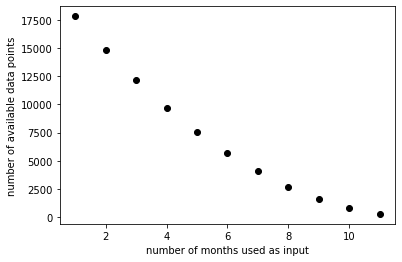

In [36]:
month_arr=np.arange(1,12)
print(size_data)
# Plot outputs
plt.scatter(month_arr, size_data,  color='black')
plt.xlabel("number of months used as input")
plt.ylabel("number of available data points")
plt.show()

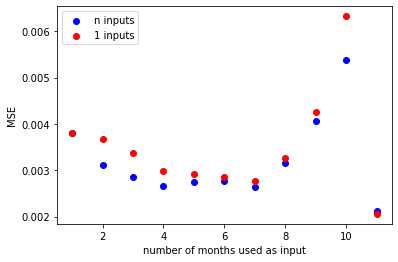

In [38]:
# Plot outputs
plt.scatter(month_arr, MSE,  color='blue',label="n inputs")
plt.scatter(month_arr,MSE1D, color='red', label="1 inputs")
plt.xlabel("number of months used as input")
plt.ylabel("MSE")
plt.legend()
plt.show()

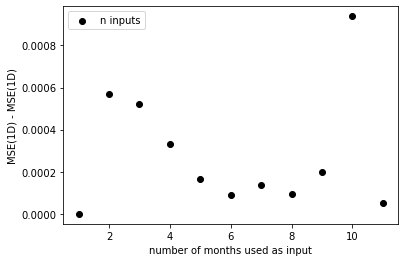

In [47]:
# Plot outputs
plt.scatter(month_arr, np.abs(np.array(MSE1D)-np.array(MSE)),  color='black',label="n inputs")
plt.xlabel("number of months used as input")
plt.ylabel("MSE(1D) - MSE(1D)")
plt.legend()
plt.show()

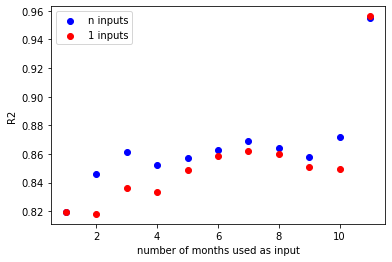

In [39]:
# Plot outputs
plt.scatter(month_arr, R2,  color='blue',label="n inputs")
plt.scatter(month_arr,R21D, color='red', label="1 inputs")
plt.xlabel("number of months used as input")
plt.ylabel("R2")
plt.legend()
plt.show()

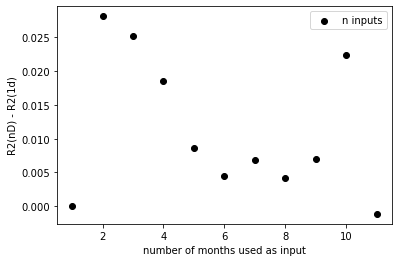

In [46]:
# Plot output
plt.scatter(month_arr, np.array(R2)-np.array(R21D),  color='black',label="n inputs")
plt.xlabel("number of months used as input")
plt.ylabel("R2(nD) - R2(1d)")
plt.legend()
plt.show()

From this we can conclude that using 1,2 or 3 months as input result in the best models since we still have sufficient data and the improment of the model is mostly a result of the extra information an not the smaller/easier data set

## Adding extra information like temperature to the linear/autoregressive models

In [77]:
NaN_t=1200
En_con=[]
#number of input months (if nim=1 we should get the same as before)
#this is the amount of months we want in our input space to predict the next monthly consumption
nim=2       
prev_con=[] #previous consumtion
#extra info
temps=[]
temps_min=[]
temps_max=[]
month_arr=[]
br_arr=[]

for i in range(df.shape[0]): # loop over all users
    meter=df.iloc[i] # = row number i  
    
    #loop over all month from januari until month 12-nim
    #if the month is higher then this we don't have enough data for the nim input variables and the 1 output variable
    for m in range (1,13-nim): 
        #load current month
        bi, ei =get_monthi(m)               #bi (begin index) ei(end index)
        month=meter[bi:ei]  #data for the month m for the row user (row) i
        row = brinfo_filled[i:i+1]

        # Count the amount of NaN's in current and last month      
        n_NaN=month.isnull().sum() 

        # Check if there are any NaN's in current and last month
        if n_NaN<NaN_t:
            for j in range(m,13-nim):
                #save input for month j,j+1,..,j+nim-1
                input_months=np.zeros(nim)
                for k in range(nim):
                    #load month for input j+k
                    bik,eik=get_monthi(j+k)
                    input_months[k]=meter[bik:eik].mean()
                #debug if statement checks for NaN in input month
                if np.isnan(np.sum(input_months)):
                    print("months=%i index=%i" %(j,i))
                    print(input_months)
                prev_con.append(input_months)
                #save output for month j+nim
                bio,eio=get_monthi(j+nim)
                En_con.append(meter[bio:eio].mean())
                #save extra information 
                temps.append(get_mean_temp(weather_avg_sorted.iloc[i:i+1],j+nim))
                temps_min.append(get_mean_temp(weather_min_sorted.iloc[i:i+1],j+nim))
                temps_max.append(get_mean_temp(weather_max_sorted.iloc[i:i+1],j+nim))
                month_arr.append(j+nim)
                br_arr.append(row[0])
                
                
            #break out of outer month loops since the inner month loop takes care of all months
            break
           

We could also add the temperature of the input months this could lead to another improvement

In [78]:
# converting list to numpy arrays: 
npprev_con=np.array(prev_con)
npEn_con=np.array(En_con).ravel()

nptemps = np.zeros(len(temps))
nptemps_min = np.zeros(len(temps_min))
nptemps_max = np.zeros(len(temps_max))
npmonth_arr = np.zeros(len(month_arr))
npbr_arr = np.zeros(len(br_arr)) #converting it into numpy array.

for i in range(len(temps)):
     nptemps[i] = temps[i]

for i in range(len(temps_min)):
     nptemps_min[i] = temps_min[i]

for i in range(len(temps_max)):
     nptemps_max[i] = temps_max[i]

for i in range(len(month_arr)):
     npmonth_arr[i] = month_arr[i]

for i in range(len(br_arr)):
    npbr_arr[i] = br_arr[i]    

In [79]:
#combine features
#we'll exluce moths for now since they're not linear
np_features= np.zeros(shape = (len(temps), nim+4))

for i in range(len(temps)):
    np_features[i, 0:nim]  = npprev_con[i,:]
    np_features[i, nim] = temps[i]
    np_features[i, nim+1] = temps_min[i]
    np_features[i, nim+2] = temps_max[i]
    np_features[i, nim+3] = npbr_arr[i]
   # np_features[i, 5] = npmonth_arr[i]

In [73]:
splitnum=np.int(0.3*npprev_con.shape[0])
# Split the data into training/testing sets
X_train_comb = np_features[:-splitnum]
X_test_comb = np_features[-splitnum:]

# Split the targets into training/testing sets
y_train = npEn_con[:-splitnum]
y_test = npEn_con[-splitnum:]


# Create linear regression object
regr_comb = linear_model.LinearRegression()

# Train the model using the training sets
regr_comb.fit(X_train_comb, y_train)


# Make predictions using the testing set
y_pred_comb = regr_comb.predict(X_test_comb)


# The coefficients
print('Coefficients: \n', regr_comb.coef_)
# The mean squared error
print('Mean squared error: %.8f'
      % mean_squared_error(y_test, y_pred_comb))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'
      % r2_score(y_test, y_pred_comb))

Coefficients: 
 [-6.44446258e-02 -4.72346132e-02  1.15438412e+00 -1.05270164e-03
 -2.79227361e-05 -1.04496744e-03  1.89534007e-03]
Mean squared error: 0.00278074
Coefficient of determination: 0.8650


output for nim=2: <br>
Coefficients: <br>
 [-1.47788769e-01  1.18374694e+00 -3.12669273e-04  1.13349017e-03
 -2.73056036e-03  1.36765033e-03] <br>
Mean squared error: 0.00299868 <br>
Coefficient of determination: 0.8513 <br>
output for nim=3: <br>
Coefficients:  <br>
 [-6.44446258e-02 -4.72346132e-02  1.15438412e+00 -1.05270164e-03
 -2.79227361e-05 -1.04496744e-03  1.89534007e-03] <br>
Mean squared error: 0.00278074 <br>
Coefficient of determination: 0.8650 <br>

## polynomail regression

In [70]:
def polfit(X_train,X_test,y_train,y_test,deg,printcoef=False):
    # Fitting Polynomial Regression to the dataset
    # source: https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386
    # Create polynomial regression object
    polynom_degree = deg

    poly_reg = PolynomialFeatures(degree = polynom_degree)

    X_poly = poly_reg.fit_transform(X_train) # Fit to data, then transform it to 
    #a new feature matrix consisting ofall polynomial combinations of the features

    pol_reg = LinearRegression()

    # Train the model using the training sets
    pol_reg.fit(X_poly, y_train)

    # polyfitting the training data:
    poly_vals = pol_reg.predict(poly_reg.fit_transform(X_train))

    # Make predictions using the testing set
    y_pred_poly = pol_reg.predict(poly_reg.fit_transform(X_test))

    # The coefficients
    if printcoef:
        print('Coefficients: \n', pol_reg.coef_)
        
    # The mean squared error
    print('Mean squared error: %.8f'
      % mean_squared_error(y_test, y_pred_poly))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.8f'
      % r2_score(y_test, y_pred_poly))

In [80]:
splitnum=np.int(0.3*npprev_con.shape[0])
# Split the data into training/testing sets
X_train_comb = np_features[:-splitnum]
X_test_comb = np_features[-splitnum:]

# Split the targets into training/testing sets
y_train = npEn_con[:-splitnum]
y_test = npEn_con[-splitnum:]

polfit(X_train_comb,X_test_comb,y_train,y_test,2,printcoef=False)

Mean squared error: 0.00274127
Coefficient of determination: 0.86409073


nim=2 <br>
Mean squared error: 0.00274127 <br>
Coefficient of determination: 0.86409073 <br>
nim=3 <br>
Mean squared error: 0.00260187 <br>
Coefficient of determination: 0.87369912 <br>

## TO DO

1) try to predict multiple month instead of 1 
2) add temperature of the imput months to the model
3) 

## Implementing KFold Enconding on previous models


In [3]:
values = {'num_bedrooms' : -1}
info_filled_br_dummy = info_sorted.fillna(value = values)
brinfo_filled_dummy = info_filled_br_dummy['num_bedrooms']
brinfo_filled_dummy
y = pd.get_dummies(info_sorted.dwelling_type, prefix='dwelling_type')

In [ ]:
def getconsumption_data2(nim)
    NaN_t=1200
    En_con=[]
    #number of input months (if nim=1 we should get the same as before)
    #this is the amount of months we want in our input space to predict the next monthly consumption     
    prev_con=[] #previous consumtion
    #extra info
    temps=[]
    temps_min=[]
    temps_max=[]
    month_arr=[]
    br_arr=[]

    for i in range(df.shape[0]): # loop over all users
        meter=df.iloc[i] # = row number i  
    
        #loop over all month from januari until month 12-nim
        #if the month is higher then this we don't have enough data for the nim input variables and the 1 output variable
        for m in range (1,13-nim): 
            #load current month
            bi, ei =get_monthi(m)               #bi (begin index) ei(end index)
            month=meter[bi:ei]  #data for the month m for the row user (row) i
            row = brinfo_filled[i:i+1]

            # Count the amount of NaN's in current and last month      
            n_NaN=month.isnull().sum() 

            # Check if there are any NaN's in current and last month
            if n_NaN<NaN_t:
                for j in range(m,13-nim):
                    #save input for month j,j+1,..,j+nim-1
                    input_months=np.zeros(nim)
                    for k in range(nim):
                        #load month for input j+k
                        bik,eik=get_monthi(j+k)
                        nput_months[k]=meter[bik:eik].mean()
                    #debug if statement checks for NaN in input month
                    if np.isnan(np.sum(input_months)):
                        print("months=%i index=%i" %(j,i))
                        print(input_months)
                    prev_con.append(input_months)
                    #save output for month j+nim
                    bio,eio=get_monthi(j+nim)
                    En_con.append(meter[bio:eio].mean())
                    #save extra information 
                    temps.append(get_mean_temp(weather_avg_sorted.iloc[i:i+1],j+nim))
                    temps_min.append(get_mean_temp(weather_min_sorted.iloc[i:i+1],j+nim))
                    temps_max.append(get_mean_temp(weather_max_sorted.iloc[i:i+1],j+nim))
                    month_arr.append(j+nim)
                    br_arr.append(row[0])
                
                
                #break out of outer month loops since the inner month loop takes care of all months
                break

           

NameError: name 'sort_data' is not defined